In [1]:
# run in the root of the repository
%cd ../..

/private/home/pfz/09-videoseal/videoseal-dev


In [17]:
import json
import argparse
import os
import omegaconf
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

from videoseal.models import Wam, build_embedder, build_extractor
from videoseal.modules.jnd import JND
from videoseal.augmentation.augmenter import Augmenter
from videoseal.data.transforms import default_transform, normalize_img, unnormalize_img
from videoseal.data.datasets import VideoDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
def load_model_from_checkpoint(exp_dir, exp_name):
    logfile_path = os.path.join(exp_dir, 'logs', exp_name + '.stdout')
    ckpt_path = os.path.join(exp_dir, exp_name, 'checkpoint.pth')

    # Load parameters from log file
    with open(logfile_path, 'r') as file:
        for line in file:
            if '__log__:' in line:
                params = json.loads(line.split('__log__:')[1].strip())
                break

    # Create an argparse Namespace object from the parameters
    args = argparse.Namespace(**params)
    print(args)
    
    # Load configurations
    for path in [args.embedder_config, args.extractor_config, args.augmentation_config]:
        path = os.path.join(exp_dir, "code", path)
    # embedder
    embedder_cfg = omegaconf.OmegaConf.load(args.embedder_config)
    args.embedder_model = args.embedder_model or embedder_cfg.model
    embedder_params = embedder_cfg[args.embedder_model]
    # extractor
    extractor_cfg = omegaconf.OmegaConf.load(args.extractor_config)
    args.extractor_model = args.extractor_model or extractor_cfg.model
    extractor_params = extractor_cfg[args.extractor_model]
    # augmenter
    augmenter_cfg = omegaconf.OmegaConf.load(args.augmentation_config)
    
    # Build models
    embedder = build_embedder(args.embedder_model, embedder_params, args.nbits)
    extractor = build_extractor(extractor_cfg.model, extractor_params, args.img_size_extractor, args.nbits)
    augmenter = Augmenter(**augmenter_cfg)
    
    # Build the complete model
    wam = Wam(embedder, extractor, augmenter, 
                   scaling_w=args.scaling_w, scaling_i=args.scaling_i)
    
    # Load the model weights
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        wam.load_state_dict(checkpoint['model'])
        print("Model loaded successfully from", ckpt_path)
        print(line)
    else:
        print("Checkpoint path does not exist:", ckpt_path)
    
    return wam

# Example usage
exp_dir = '/checkpoint/pfz/2024_logs/0911_vseal_pw'
exp_name = '_extractor_model=sam_tiny'

wam = load_model_from_checkpoint(exp_dir, exp_name)
wam.eval()
wam.to(device)

Namespace(train_dir='/datasets01/COCO/060817/train2014/', train_annotation_file='/datasets01/COCO/060817/annotations/instances_train2014.json', val_dir='/datasets01/COCO/060817/val2014/', val_annotation_file='/datasets01/COCO/060817/annotations/instances_val2014.json', output_dir='/checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny', embedder_config='configs/embedder.yaml', augmentation_config='configs/simple_augs.yaml', extractor_config='configs/extractor.yaml', attenuation_config='configs/attenuation.yaml', embedder_model='unet_small2', extractor_model='sam_tiny', nbits=32, img_size=256, img_size_extractor=256, attenuation='None', scaling_w=0.4, scaling_w_schedule=None, scaling_i=1.0, threshold_mask=0.6, optimizer='AdamW,lr=1e-4', optimizer_d=None, scheduler='CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', epochs=100, batch_size=16, batch_size_eval=32, temperature=1.0, workers=8, resume_from=None, lambda_det=0.0, lambda_dec=1.0, lambda_i=0.0

/tmp/ipykernel_4127345/2942484245.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Model loaded successfully from /checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny/checkpoint.pth
__log__:{"train_dir": "/datasets01/COCO/060817/train2014/", "train_annotation_file": "/datasets01/COCO/060817/annotations/instances_train2014.json", "val_dir": "/datasets01/COCO/060817/val2014/", "val_annotation_file": "/datasets01/COCO/060817/annotations/instances_val2014.json", "output_dir": "/checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny", "embedder_config": "configs/embedder.yaml", "augmentation_config": "configs/simple_augs.yaml", "extractor_config": "configs/extractor.yaml", "attenuation_config": "configs/attenuation.yaml", "embedder_model": "unet_small2", "extractor_model": "sam_tiny", "nbits": 32, "img_size": 256, "img_size_extractor": 256, "attenuation": "None", "scaling_w": 0.4, "scaling_w_schedule": null, "scaling_i": 1.0, "threshold_mask": 0.6, "optimizer": "AdamW,lr=1e-4", "optimizer_d": null, "scheduler": "CosineLRScheduler,lr_min=1e-6,t_initi

Wam(
  (embedder): UnetEmbedder(
    (unet): UNetMsg(
      (msg_processor): MsgProcessor(
        (msg_embeddings): Embedding(64, 64)
      )
      (inc): ResnetBlock(
        (double_conv): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ChanRMSNorm()
          (2): SiLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ChanRMSNorm()
          (5): SiLU()
        )
        (res_conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (downs): ModuleList(
        (0): DBlock(
          (down): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (conv): ResnetBlock(
            (double_conv): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): ChanRMSNorm()
              (2): SiLU()
              (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1,

In [28]:
# print(os.listdir("/private/home/pfz/_images"))
# img = "/private/home/pfz/_images/chao.png"
img_tensor = "/private/home/tomsander/ai_signature/output/imgs/00000.png"
img_tensor = Image.open(img_tensor, "r").convert("RGB")  # keep only rgb channels
img_tensor = default_transform(img_tensor).unsqueeze(0).to(device)

In [36]:
attenuation_cfg = "configs/attenuation.yaml"
attenuation = "jnd_1_3"
attenuation_cfg = omegaconf.OmegaConf.load(attenuation_cfg)[attenuation]
attenuation = JND(**attenuation_cfg).to(device)
attenuation.preprocess = unnormalize_img
attenuation.postprocess = normalize_img

wam.attenuation = attenuation
wam.scaling_w = 2.0
wam.scaling_i = 1.0

In [37]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
resize = transforms.Resize((256, 256))

@torch.no_grad()
def test_model_on_image(
    model: Wam,
    imgs: torch.Tensor,
) -> dict:
    """
    Test the given model on the provided image tensor, create the watermarked image, and plot the results.
    
    Args:
    - model: The trained model.
    - imgs: A tensor representing the image, normalized as wam.
    """
    # Generate random message for watermarking
    msgs = model.get_random_msg(imgs.shape[0])  # b x k
    msgs = msgs.to('cuda')

    # get original size
    bsz, _, h, w = imgs.shape

    # Generate watermark delta
    delta = model.embedder(resize(imgs), msgs)
    delta = nn.functional.interpolate(delta, (h, w), mode='bilinear', align_corners=False)
    
    # Create watermarked image
    imgs_w =  model.scaling_i * imgs + model.scaling_w * delta
    
    # attenuation
    if model.attenuation is not None:
        imgs_w = model.attenuation(imgs, imgs_w)

    # resize to 256x256 and augment
    imgs_aug = imgs_w
    imgs_aug = resize(imgs_aug)

    # detect watermark
    preds = wam.detector(imgs_aug)
    mask_preds = preds[:, 0:1]  # b ?
    bit_preds = preds[:, 1:]  # b k ?

    outputs = {
        'imgs': imgs,  # b 3 h w
        'imgs_w': imgs_w,  # b 3 h w
        'mask_preds': mask_preds,  # b 1 h w
        'msgs': msgs,  # b k
        'bit_preds': bit_preds,  # b k h w
    }
    return outputs

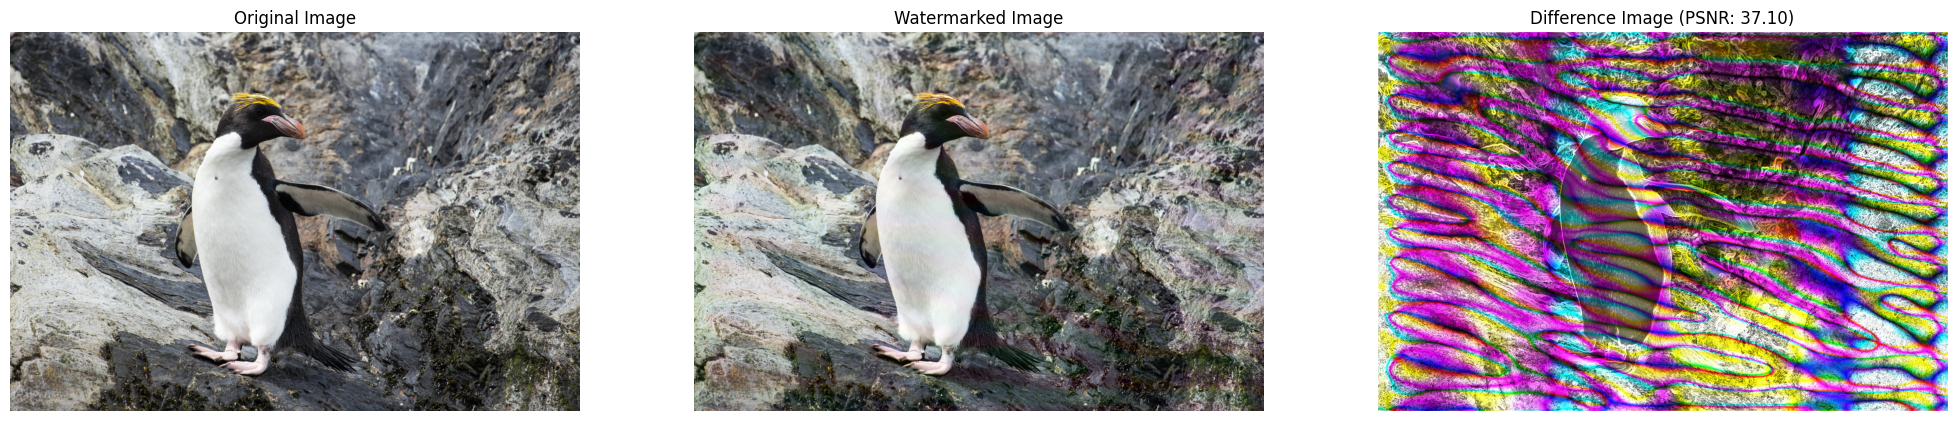

0.75


In [39]:
outputs = test_model_on_image(wam, img_tensor)

def torch_to_np(img_tensor):
    img_tensor = unnormalize_img(img_tensor).clamp(0, 1)
    img_tensor = img_tensor.squeeze().permute(1, 2, 0).cpu()
    return img_tensor.numpy()


def plot_outputs(outputs):
    """
    Plot the outputs from the test_model_on_image function.
    
    Args:
    - outputs: A dictionary containing the outputs from the test_model_on_image function.
    """
    # prepare images
    imgs = torch_to_np(outputs['imgs'])
    imgs_w = torch_to_np(outputs['imgs_w'])
    delta = (outputs['imgs_w'] - outputs['imgs']).squeeze().permute(1, 2, 0).cpu().numpy()
    delta = np.clip(np.abs(10 * delta), 0, 1)
    psnr = peak_signal_noise_ratio(imgs, imgs_w)
    
    # plot images: original, watermarked, difference
    plt.figure(figsize=(25, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(imgs)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(imgs_w)
    plt.title('Watermarked Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(delta), cmap='hot')
    plt.title('Difference Image (PSNR: {:.2f})'.format(psnr))
    plt.axis('off')
    plt.show()

    # prepare masks
    preds = outputs['bit_preds'] > 0.5
    targets = outputs['msgs']
    correct = (preds == targets).float()  # b k
    bit_accs = correct.mean(dim=1)  # b 1
    bit_accs = bit_accs.squeeze().cpu().numpy()

    # plot masks
    print(bit_accs)

plot_outputs(outputs)